In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as sf
from matplotlib import pyplot as plt
from pyspark.sql.functions import col, avg, date_format,month,hour,lag, date_sub,lit
from pyspark.sql.window import Window
from pyspark.sql.types import DateType, DoubleType
from pyspark.sql.functions import broadcast
import pandas as pd
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, OneHotEncoder
from datetime import datetime, timedelta, date
from pyspark.ml import Pipeline
import pyspark

In [2]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [3]:
def prepare_dataset(resampled_df,window_period,week_lag):
    # window period = 6 for lag input for same hour,same-1,same-2 
    window = Window.partitionBy('cluster_id').orderBy('date','hour')
    for lag_hour in range(0,3):
        for diff in range(1,window_period+1):
            resampled_df = resampled_df.withColumn('{}_diff_energy_t_{}'.format(diff,lag_hour),lag(resampled_df['energy(kWh/h)'], count=24*diff+lag_hour).over(window)) 
    for lag_week in range(1,week_lag+1):
        resampled_df = resampled_df.withColumn('diff_energy_week_t_{}'.format(lag_week),lag(resampled_df['energy(kWh/h)'], count=24*7*lag_week).over(window)) 
    df_resample_lag = resampled_df

    # Mean of previous 6 days
    df_resample_lag = df_resample_lag.withColumn("rnk",sf.dense_rank().over(Window.partitionBy('cluster_id').orderBy('date')))
    for days in range(1,window_period+1):
        df_resample_lag = df_resample_lag.withColumn("mean_{}".format(days),avg("energy(kWh/h)").over(Window.partitionBy("cluster_id").orderBy("rnk").rangeBetween(-days,-days)))
#     df_resample_lag.show()
    # Min power of previous 2 days
    for days in range(1,window_period+1):
        df_resample_lag = df_resample_lag.withColumn("min_{}".format(days),sf.min("energy(kWh/h)").over(Window.partitionBy("cluster_id").orderBy("rnk").rangeBetween(-days,-days)))
        df_resample_lag = df_resample_lag.withColumn("max_{}".format(days),sf.max("energy(kWh/h)").over(Window.partitionBy("cluster_id").orderBy("rnk").rangeBetween(-days,-days)))
    
    return df_resample_lag

In [4]:
def add_weather_feature(df):
    weather_data = sqlcontext.read.csv(base_path+"weather_hourly_darksky.csv",header=True,inferSchema=True)
    weather_daily_data = sqlcontext.read.csv(base_path+"weather_daily_darksky.csv",header=True,inferSchema=True)
    weather_daily_data = weather_daily_data.select(date_format("temperatureMaxTime","yyyy-MM-dd").alias("date2"),"temperatureMax","temperatureMin")
    weather_data = weather_data.withColumn("hour1",hour(weather_data["time"]))
    weather_data = weather_data.withColumn("date1",date_format(weather_data["time"],"yyyy-MM-dd").cast(DateType()))
    weather_data = weather_data.drop("time","icon","temperature")
    weather_data = weather_data.join(broadcast(weather_daily_data),(weather_daily_data.date2 == weather_data.date1))
    weather_data.printSchema()
    df_full_dataset = df.join(broadcast(weather_data),(df.date == weather_data.date1) & (df.hour == weather_data.hour1))
    df_full_dataset = df_full_dataset.drop("hour1","date1").cache()
    df_full_dataset.take(1)
    df_full_dataset = df_full_dataset.na.drop()
    return df_full_dataset

def add_holiday_feature(df):
    holiday_data = sqlcontext.read.csv(base_path+"uk_bank_holidays.csv",header=True,inferSchema=True)
    holiday_data = holiday_data.withColumn("Bank holidays",date_format(holiday_data["Bank holidays"],"yyyy-MM-dd").cast(DateType()))
    holiday_data = holiday_data.select("Bank holidays")
    holiday_data = holiday_data.withColumn("holiday",lit(1))
    feature_df = df.join(holiday_data,holiday_data["Bank holidays"] == df["date"],how="left")
    feature_df = feature_df.fillna({'holiday':'0'})
    feature_df = feature_df.drop("Bank holidays")
    feature_df = feature_df.withColumn("Weekday/end",sf.when((col("weekDay")==str("Sat")) | (col("weekDay")==str("Sat")),1).otherwise(0))
    feature_df = feature_df.na.drop()
    return feature_df

# def acorn_info(df,household_info):
#     Acorn_data_group = household_info.select("LCLid","stdorToU","Acorn_grouped")
#     Acorn_data_group.select("Acorn_grouped").distinct().collect()
#     possible_group = ["Comfortable","Affluent","Adversity"]
#     Acorn_data_group = Acorn_data_group.filter(Acorn_data_group.Acorn_grouped.isin(possible_group))
#     feature_df = df.join(Acorn_data_group,["LCLid"])                # preventing duplicate column in df
#     feature_df.printSchema()
#     #Acorn_data_group.select("stdorToU").distinct().collect()
#     feature_df.take(1)
#     return feature_df



    

In [5]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)

In [6]:
household_info = sqlcontext.read.csv(base_path+"informations_households.csv",header=True,inferSchema=True)
household_mini = household_info
# household_mini = household_info.limit(1)

In [7]:
household_mini.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [8]:
def resample_to_1_hr(df):
    df = df.select("LCLid","tstp","energy(kWh/hh)",date_format("tstp","yyyy-MM-dd").alias("date"),date_format("tstp",'HH:mm').alias("start time"),date_format("tstp",'E').alias("weekDay"),month("tstp").alias("month"),hour("tstp").alias("hour"))
    df = df.withColumn("energy(kWh/hh)",df["energy(kWh/hh)"].cast("float"))
    df1 = (df.groupby('LCLid',"date","hour").sum("energy(kWh/hh)")).orderBy('date','hour',ascending=True)
    df1 = df1.withColumnRenamed("sum(energy(kWh/hh))","energy(kWh/h)")
    resampled_df = df1.select("LCLid","date","hour","energy(kWh/h)",month("date").alias("month"),date_format("date",'E').alias("weekDay"))
    resampled_df = resampled_df.withColumn("energy(kWh/h)", sf.round(resampled_df["energy(kWh/h)"], 3))
    resampled_df = resampled_df.withColumn("date", resampled_df["date"].cast(DateType()))
    return resampled_df
# resampled_df.count()

In [9]:
flag = 0
df_full = []
df_file = household_mini.select("file").distinct()
# df_file.show()
count = 0
for row in df_file.rdd.collect():
    file = row.file
    print(file,count)
    count += 1
    file_path = base_path + "halfhourly_dataset/"+ file+".csv"
    half_hourly_consumption_data = sqlcontext.read.csv(file_path,header=True,inferSchema=True).cache()
    half_hourly_consumption_data.dropna(how='any')
    half_hourly_consumption_data = resample_to_1_hr(half_hourly_consumption_data)
    if flag == 0:
        df_full = sqlcontext.createDataFrame([],half_hourly_consumption_data.schema)
        flag = 1
    df_full = df_full.union(half_hourly_consumption_data)
    df_full = df_full.cache()

block_64 0
block_91 1
block_39 2
block_43 3
block_77 4
block_19 5
block_35 6
block_53 7
block_26 8
block_20 9
block_52 10
block_12 11
block_21 12
block_36 13
block_89 14
block_84 15
block_49 16
block_93 17
block_99 18
block_18 19
block_44 20
block_8 21
block_71 22
block_104 23
block_4 24
block_29 25
block_38 26
block_47 27
block_48 28
block_42 29
block_85 30
block_27 31
block_108 32
block_76 33
block_1 34
block_3 35
block_56 36
block_94 37
block_72 38
block_75 39
block_78 40
block_62 41
block_101 42
block_46 43
block_110 44
block_32 45
block_51 46
block_45 47
block_59 48
block_40 49
block_15 50
block_95 51
block_96 52
block_5 53
block_68 54
block_28 55
block_97 56
block_82 57
block_69 58
block_70 59
block_61 60
block_24 61
block_33 62
block_23 63
block_31 64
block_67 65
block_0 66
block_14 67
block_41 68
block_100 69
block_22 70
block_109 71
block_83 72
block_30 73
block_88 74
block_98 75
block_106 76
block_37 77
block_10 78
block_80 79
block_103 80
block_55 81
block_73 82
block_111 83

In [10]:
df_full.count()

83919248

In [10]:
LCLid_under_Consideration = sqlcontext.read.csv(base_path+"Feature_File/Cleaned_2013_Features_mth_5.csv",header=True)
LCLid_under_Consideration = LCLid_under_Consideration.select("LCLid").distinct()
# LCLid_under_Consideration.count() #3930

In [11]:
# df_full1 = df_full.filter((df_full.date >= date(2012,12,1)) & (df_full.date <= date(2013,12,31)))
# df_full = df_full.filter((df_full.date >= date(2013,1,1)) & (df_full.date <= date(2013,12,31)))
# df_full = df_full.na.drop()
# print(df_full.count())
# year_df = df_full.groupBy("LCLid").count()
# print(year_df.count())
# year_df = year_df.filter(year_df["count"] >= 8760 )
# print("Total user in 2013 with full evidence ", year_df.select("LCLid").distinct().count())
# df_full = df_full1.join(broadcast(year_df),["LCLid"])
# df_full.count()

df_full = df_full.join(broadcast(LCLid_under_Consideration),["LCLid"])
df_full = df_full.filter((df_full.date >= date(2012,12,1)) & (df_full.date <= date(2013,12,31)))
# print("Total user in 2013 with full evidence ", df_full.select("LCLid").distinct().count())

In [12]:
df_full.show(1)

+---------+----------+----+-------------+-----+-------+
|    LCLid|      date|hour|energy(kWh/h)|month|weekDay|
+---------+----------+----+-------------+-----+-------+
|MAC003532|2012-12-01|   0|        1.066|   12|    Sat|
+---------+----------+----+-------------+-----+-------+
only showing top 1 row



In [13]:
df_full.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)



## Week aggregated Load

In [14]:
start_date = date(2013,7,15)
end_date = date(2013,7,21)
temp_df = df_full.groupBy("date","hour").sum("energy(kWh/h)").orderBy("date","hour")
temp_df = temp_df.where((df_full["date"] >= start_date) &(df_full["date"] <= end_date))
temp_df = temp_df.toPandas()

0 0
0 1
0 2
1 3
1 0
1 1
2 2


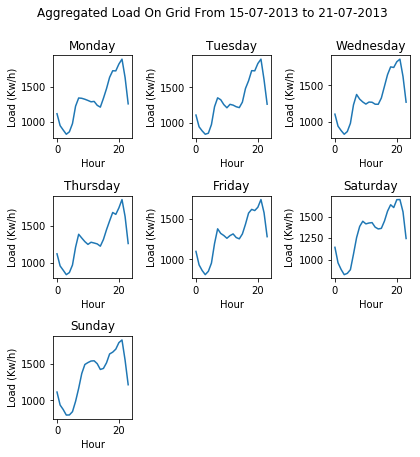

In [15]:
start_date = date(2013,7,15)
end_date = date(2013,7,21)
nrow = 3
ncol = 3
fig,ax = plt.subplots(nrow,ncol,figsize=(6,6))
cnt = 0
fig.suptitle("Aggregated Load On Grid From 15-07-2013 to 21-07-2013",y=1.05)
week = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
while start_date <= end_date:
    df_day = temp_df.loc[temp_df["date"] == start_date]
    print(cnt//nrow,cnt%4)
    ax[cnt//nrow,cnt%ncol].plot(df_day["hour"],df_day["sum(energy(kWh/h))"])
    ax[cnt//nrow,cnt%ncol].set_xlabel("Hour")
    ax[cnt//nrow,cnt%ncol].set_ylabel("Load (Kw/h)")
    ax[cnt//nrow,cnt%ncol].set_title(week[cnt])
    start_date = start_date + timedelta(1)
    cnt += 1
fig.tight_layout()
fig.delaxes(ax[2,2])
fig.delaxes(ax[2,1])

In [16]:
fig.savefig(base_path+"/plot/weekly_load.png")

## Week plot ended

In [26]:
cluster_file = sqlcontext.read.csv(base_path+"cluster_info_b-k_means_k-8.csv",inferSchema=True,header=True)
LCLid_With_Cluster_id = df_full.join(broadcast(cluster_file),["LCLid"])
LCLid_With_Cluster_id = LCLid_With_Cluster_id.drop("_c0","count")
# LCLid_With_Cluster_id.count()  #34422870

In [27]:
LCLid_With_Cluster_id.select("cluster_id").distinct().count()

8

In [28]:
# Resampling to 1 hour and extracting variable like month,hour,weekday etc.
# df = LCLid_With_Cluster_id.select("cluster_id","tstp","energy(kWh/hh)",date_format("tstp","yyyy-MM-dd").alias("date"),date_format("tstp",'HH:mm').alias("start time"),date_format("tstp",'E').alias("weekDay"),month("tstp").alias("month"),hour("tstp").alias("hour"))
# df = df.withColumn("energy(kWh/hh)",df["energy(kWh/hh)"].cast(DoubleType()))
df1 = (LCLid_With_Cluster_id.groupby('cluster_id',"date","hour").sum("energy(kWh/h)")).orderBy('date','hour',ascending=True)
df1 = df1.withColumnRenamed("sum(energy(kWh/h))","energy(kWh/h)")
resampled_df = df1.select("cluster_id","date","hour","energy(kWh/h)",month("date").alias("month"),date_format("date",'E').alias("weekDay"))
resampled_df = resampled_df.withColumn("energy(kWh/h)", sf.round(resampled_df["energy(kWh/h)"], 3))
resampled_df = resampled_df.withColumn("date", resampled_df["date"].cast(DateType()))
#resampled_df.count()    #70072

In [29]:
feature_df = prepare_dataset(resampled_df,7,4) #70072
# print(feature_df.count())
add_weather_feature_df = add_weather_feature(feature_df)
add_holiday_feature_df = add_holiday_feature(add_weather_feature_df)
# add_acorn_info_df = acorn_info(add_holiday_feature_df,household_info)
add_acorn_info_df = add_holiday_feature_df
add_acorn_info_df.printSchema()

root
 |-- visibility: double (nullable = true)
 |-- windBearing: integer (nullable = true)
 |-- dewPoint: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- apparentTemperature: double (nullable = true)
 |-- windSpeed: double (nullable = true)
 |-- precipType: string (nullable = true)
 |-- humidity: double (nullable = true)
 |-- summary: string (nullable = true)
 |-- hour1: integer (nullable = true)
 |-- date1: date (nullable = true)
 |-- date2: string (nullable = true)
 |-- temperatureMax: double (nullable = true)
 |-- temperatureMin: double (nullable = true)

root
 |-- cluster_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: d

In [30]:
add_acorn_info_df.count()       #64648

70592

In [31]:
final_feature_df = add_acorn_info_df
print(final_feature_df.count())
inputCols = ["weekDay","precipType","summary",]
outputCols = ["weekDay_index","precipType_index","summary_index"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(final_feature_df) for column in inputCols ]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(final_feature_df).transform(final_feature_df)

70592


In [32]:
df = df.filter(df.date>=date(2013,1,1))
df.count()

70016

In [33]:
df.toPandas().to_csv(base_path+"bk=8_means_Feature.csv")

In [34]:
df.take(1)

[Row(cluster_id=1, date=datetime.date(2013, 1, 1), hour=0, energy(kWh/h)=265.413, month=1, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_1=235.955, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, rnk=32, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=